In [3]:
import os
import glob
import random
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from tifffile import imsave
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler


In [2]:
scaler = MinMaxScaler()

In [ ]:
TRAIN_DATASET_PATH = "../BraTS2020_DataSet/MICCAI_BraTS2020_TrainingData/"
VALIDATION_DATASET_PATH = "../BraTS2020_DataSet/MICCAI_BraTS2020_ValidationData/"

# **Approach Testing On Single Image**

In [23]:
test_image_flair= nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_flair.nii').get_fdata()
print(test_image_flair.max())

1854.603271484375


In [24]:
#Scalers are applied to 1D so let us reshape and then reshape back to original shape. 

test_image_flair = scaler.fit_transform(test_image_flair.reshape(-1, test_image_flair.shape[-1])).reshape(test_image_flair.shape)

In [25]:
test_image_t1= nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_t1.nii').get_fdata()
test_image_t1= scaler.fit_transform(test_image_t1.reshape(-1, test_image_t1.shape[-1])).reshape(test_image_t1.shape)

In [26]:
test_image_t1ce=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_t1ce.nii').get_fdata()
test_image_t1ce=scaler.fit_transform(test_image_t1ce.reshape(-1, test_image_t1ce.shape[-1])).reshape(test_image_t1ce.shape)

In [27]:

test_image_t2=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_t2.nii').get_fdata()
test_image_t2=scaler.fit_transform(test_image_t2.reshape(-1, test_image_t2.shape[-1])).reshape(test_image_t2.shape)

In [28]:
test_mask = nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_seg.nii').get_fdata()
test_mask = test_mask.astype(np.uint8)

In [29]:
print(np.unique(test_mask))  #0, 1, 2, 4 (Need to reencode to 0, 1, 2, 3)
test_mask[test_mask==4] = 3  #Reassign mask values 4 to 3
print(np.unique(test_mask)) 

[0 1 2 4]
[0 1 2 3]


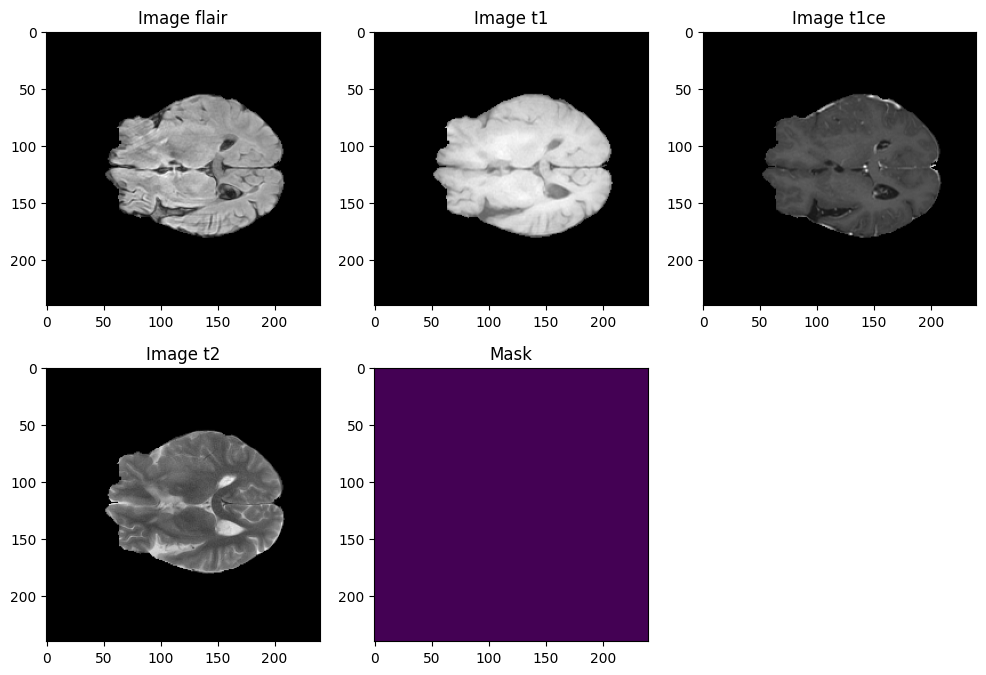

In [35]:
# Each image is of size (240,240,155) which means each 3D image have 155 layers of size 240*240
# Here we ae randomly taking a slice and analysing its all 4 channels

##################
n_slice=random.randint(0, test_mask.shape[2])

##########################################################

plt.figure(figsize=(12, 8))

plt.subplot(231)
plt.imshow(test_image_flair[:,:,n_slice], cmap='gray')
plt.title('Image flair')
plt.subplot(232)
plt.imshow(test_image_t1[:,:,n_slice], cmap='gray')
plt.title('Image t1')
plt.subplot(233)
plt.imshow(test_image_t1ce[:,:,n_slice], cmap='gray')
plt.title('Image t1ce')
plt.subplot(234)
plt.imshow(test_image_t2[:,:,n_slice], cmap='gray')
plt.title('Image t2')
plt.subplot(235)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

In [36]:
##################################################
#PART 2: Explore the process of combining images to channels and divide them to patches
#Includes...
#Combining all 4 images to 4 channels of a numpy array.
#
################################################
#Flair, T1CE, annd T2 have the most information
#Combine t1ce, t2, and flair into single multichannel image, order doesnt matters

################ Multichannel 3D volume

combined_x = np.stack([test_image_flair, test_image_t1ce, test_image_t2], axis=3)

In [37]:
#Crop to a size to be divisible by 64 so we can later extract 64x64x64 patches. 
#cropping x, y, and z
#combined_x=combined_x[24:216, 24:216, 13:141]

combined_x=combined_x[56:184, 56:184, 13:141] #Crop to 128x128x128x4

In [38]:
#Do the same for mask
test_mask = test_mask[56:184, 56:184, 13:141]

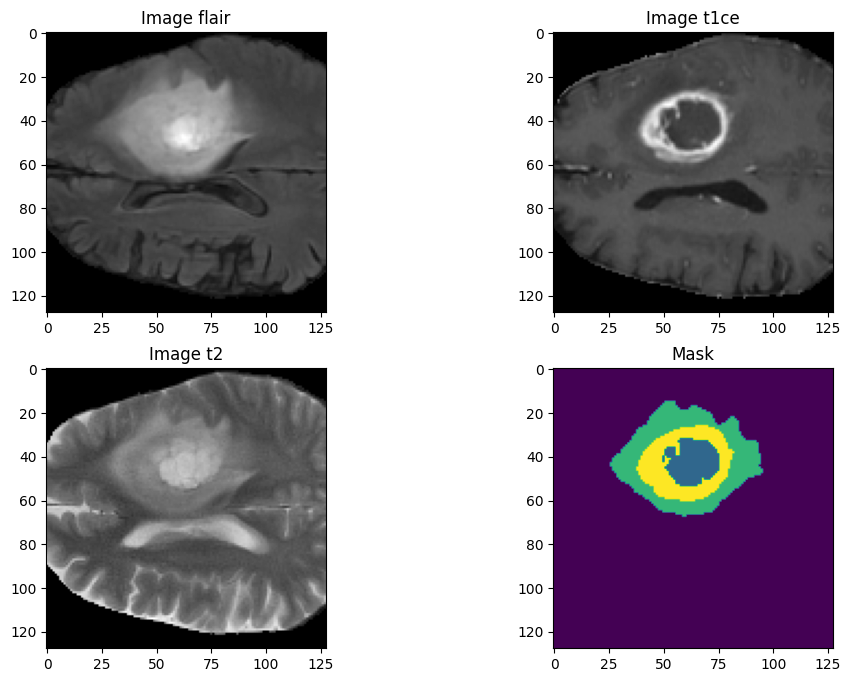

In [40]:
n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))


plt.subplot(221)
plt.imshow(combined_x[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(combined_x[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(combined_x[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

In [45]:
os.makedirs("../BraTS2020_DataSet/BraTS2020_numpy", exist_ok=True)
#os.makedirs("../BraTS2020_DataSet/BraTS2020_numpy/valid", exist_ok=True)

In [46]:
####### imsave('BraTS2020_TrainingData/combined255.tif', combined_x)

np.save('../BraTS2020_DataSet/BraTS2020_numpy/combined255.npy', combined_x)

In [47]:
#Verify image is being read properly
#my_img=imread('BraTS2020_TrainingData/combined255.tif')

my_img=np.load('../BraTS2020_DataSet/BraTS2020_numpy/combined255.npy')

test_mask = to_categorical(test_mask, num_classes=4)

# **Applying The Aove Aproach To Entire Dataset**

In [48]:
#Now let us apply the same as above to all the images...
#Merge channels, crop, patchify, save
#GET DATA READY =  GENERATORS OR OTHERWISE

#Keras datagenerator does ntot support 3d


## Train Data Conversion to Numpy Arrays

In [63]:
######### images lists harley

#t1_list = sorted(glob.glob('BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*t1.nii'))
t2_list = sorted(glob.glob('../BraTS2020_DataSet/MICCAI_BraTS2020_TrainingData/*/*t2.nii'))
t1ce_list = sorted(glob.glob('../BraTS2020_DataSet/MICCAI_BraTS2020_TrainingData/*/*t1ce.nii'))
flair_list = sorted(glob.glob('../BraTS2020_DataSet/MICCAI_BraTS2020_TrainingData/*/*flair.nii'))
mask_list = sorted(glob.glob('../BraTS2020_DataSet/MICCAI_BraTS2020_TrainingData/*/*seg.nii'))


In [65]:
len(mask_list)

369

In [66]:
#Each volume generates 18 64x64x64x4 sub-volumes. 
#Total 369 volumes = 6642 sub volumes


In [69]:
os.makedirs("../BraTS2020_DataSet/BraTS2020_numpy/input_data_3channels/images", exist_ok=True)
os.makedirs("../BraTS2020_DataSet/BraTS2020_numpy/input_data_3channels/masks", exist_ok=True)

In [70]:
for img in range(len(t2_list)):   #Using t1_list as all lists are of same size
    print("Now preparing image and masks number: ", img)
      
    temp_image_t2=nib.load(t2_list[img]).get_fdata()
    temp_image_t2=scaler.fit_transform(temp_image_t2.reshape(-1, temp_image_t2.shape[-1])).reshape(temp_image_t2.shape)
   
    temp_image_t1ce=nib.load(t1ce_list[img]).get_fdata()
    temp_image_t1ce=scaler.fit_transform(temp_image_t1ce.reshape(-1, temp_image_t1ce.shape[-1])).reshape(temp_image_t1ce.shape)
   
    temp_image_flair=nib.load(flair_list[img]).get_fdata()
    temp_image_flair=scaler.fit_transform(temp_image_flair.reshape(-1, temp_image_flair.shape[-1])).reshape(temp_image_flair.shape)
        
    temp_mask=nib.load(mask_list[img]).get_fdata()
    temp_mask=temp_mask.astype(np.uint8)
    temp_mask[temp_mask==4] = 3  #Reassign mask values 4 to 3
    #print(np.unique(temp_mask))
    
    
    temp_combined_images = np.stack([temp_image_flair, temp_image_t1ce, temp_image_t2], axis=3)
    
    #Crop to a size to be divisible by 64 so we can later extract 64x64x64 patches. 
    #cropping x, y, and z
    temp_combined_images=temp_combined_images[56:184, 56:184, 13:141]
    temp_mask = temp_mask[56:184, 56:184, 13:141]
    

    
    val, counts = np.unique(temp_mask, return_counts=True)
    
    if (1 - (counts[0]/counts.sum())) > 0.01:  #At least 1% useful volume with labels that are not 0
        print("Save Me")
        temp_mask= to_categorical(temp_mask, num_classes=4)
        np.save('../BraTS2020_DataSet/BraTS2020_numpy/input_data_3channels/images/image_'+str(img)+'.npy', temp_combined_images)
        
        np.save('../BraTS2020_DataSet/BraTS2020_numpy/input_data_3channels/masks/mask_'+str(img)+'.npy', temp_mask)
        
    else:
        print("I am useless")

Now preparing image and masks number:  0
Save Me
Now preparing image and masks number:  1
Save Me
Now preparing image and masks number:  2
Save Me
Now preparing image and masks number:  3
Save Me
Now preparing image and masks number:  4
I am useless
Now preparing image and masks number:  5
Save Me
Now preparing image and masks number:  6
Save Me
Now preparing image and masks number:  7
Save Me
Now preparing image and masks number:  8
Save Me
Now preparing image and masks number:  9
Save Me
Now preparing image and masks number:  10
Save Me
Now preparing image and masks number:  11
Save Me
Now preparing image and masks number:  12
Save Me
Now preparing image and masks number:  13
Save Me
Now preparing image and masks number:  14
Save Me
Now preparing image and masks number:  15
Save Me
Now preparing image and masks number:  16
Save Me
Now preparing image and masks number:  17
Save Me
Now preparing image and masks number:  18
Save Me
Now preparing image and masks number:  19
Save Me
Now p

## Valid Data Conversion To Numpy Arrays


Repeat the same from above for validation data folder OR
Split training data into train and validation


```
Code for splitting folder into train, test, and val.
Once the new folders are created rename them and arrange in the format below to be used
for semantic segmentation using data generators. 

pip install split-folders
```


In [1]:
import os
import splitfolders

In [2]:
import splitfolders  # or import split_folders

os.makedirs("../BraTS2020_DataSet/BraTS2020_numpy/data_split_128", exist_ok=True)

input_folder = '../BraTS2020_DataSet/BraTS2020_numpy/input_data_3channels/'
output_folder = '../BraTS2020_DataSet/BraTS2020_numpy/data_split_128/'

# Split with a ratio.
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.

splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.75, .25), group_prefix=None) # default values
########################################
